In [15]:
import os
from time import sleep
from glob import glob
import random
from tqdm import tqdm
import copy
import ntpath
import seaborn as sns

import numpy as np
from imageio import imread
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, matthews_corrcoef, classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.models import resnet18


# Data Analysis

In [ ]:
# Common classes of the datasets and their labels: 
# Highly underrepresented classes like atypical lymphocytes and smudge cells were left out.

label_map_all = {
        'basophil': 0,
        'eosinophil': 1,
        'erythroblast': 2,
        'myeloblast' : 3,
        'promyelocyte': 4,
        'myelocyte': 5,
        'metamyelocyte': 6,
        'neutrophil_banded': 7,
        'neutrophil_segmented': 8,
        'monocyte': 9,
        'lymphocyte_typical': 10
    }

label_map_reverse = {
        0: 'basophil',
        1: 'eosinophil',
        2: 'erythroblast',
        3: 'myeloblast',
        4: 'promyelocyte',
        5: 'myelocyte',
        6: 'metamyelocyte',
        7: 'neutrophil_banded',
        8: 'neutrophil_segmented',
        9: 'monocyte',
        10: 'lymphocyte_typical'
    }

# The unlabeled WBC dataset gets the classname 'Data-Val' for every image

label_map_pred = {
    'DATA-VAL': 0
}

In [14]:
metadata = pd.read_csv('metadata.csv')
metadata

,Image,file,label,dataset,set,mean1,mean2,mean3
0,BA_100102.jpg,Datasets/Acevedo_20/basophil/BA_100102.jpg,basophil,Ace_20,train,224.147949,192.992011,181.520684
1,BA_101381.jpg,Datasets/Acevedo_20/basophil/BA_101381.jpg,basophil,Ace_20,train,216.880395,185.347467,180.204591
2,BA_101611.jpg,Datasets/Acevedo_20/basophil/BA_101611.jpg,basophil,Ace_20,train,218.369314,182.833150,181.483938
3,BA_102039.jpg,Datasets/Acevedo_20/basophil/BA_102039.jpg,basophil,Ace_20,train,212.396771,178.227456,180.590029
4,BA_102750.jpg,Datasets/Acevedo_20/basophil/BA_102750.jpg,basophil,Ace_20,train,226.372008,194.938170,184.035889
...,...,...,...,...,...,...,...,...
34198,995.TIF,Datasets/WBC1/DATA-VAL/995.TIF,DATA-VAL,WBC1,train,158.898088,140.900053,180.112944
34199,996.TIF,Datasets/WBC1/DATA-VAL/996.TIF,DATA-VAL,WBC1,train,144.568094,113.955319,166.413966
34200,997.TIF,Datasets/WBC1/DATA-VAL/997.TIF,DATA-VAL,WBC1,train,170.265685,145.219063,188.039786
34201,998.TIF,Datasets/WBC1/DATA-VAL/998.TIF,DATA-VAL,WBC1,train,180.459660,147.819746,188.145870


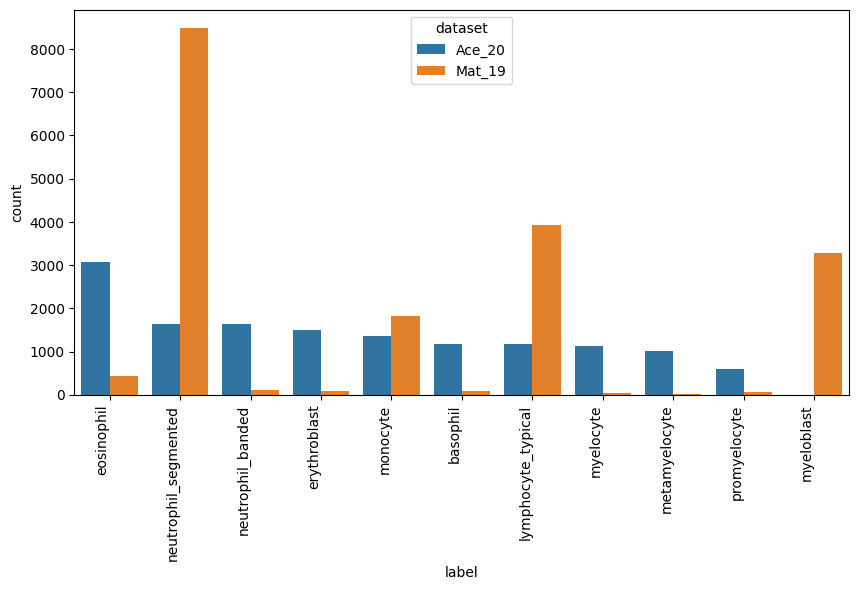

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=metadata[metadata['dataset'] != 'WBC1'].groupby(['dataset'])['label'].value_counts().rename('count').reset_index(), y='count', hue='dataset', x='label', ax=ax)
_ = ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')

# Classification

In [134]:
from models import utils
from tllib.alignment.mdd import ImageClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

# load dataset
class test:
    source = 'AM'
    target = 'W'
    root = 'Datasets'
    data = 'WBC'
    workers = 4
    batch_size = 32

args = test()
num_classes, test_loader, train_source_loader, train_target_loader, val_loader = utils.load_datasets(args)

# load checkpoint
fname = 'logs/final/checkpoints/best_val_snd.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(fname)

# load model
backbone = utils.get_model('resnet18')
num_classes = 11
bottleneck_dim = 1024
pool_layer = None
classifier = ImageClassifier(backbone, num_classes, bottleneck_dim=bottleneck_dim, width=bottleneck_dim, pool_layer=pool_layer).to(device)
_ = classifier.load_state_dict(checkpoint)

train_source_transforms:  [Compose([
  CenterCrop(always_apply=False, p=1.0, height=300, width=300),
  RandomCrop(always_apply=False, p=1.0, height=224, width=224),
  Blur(always_apply=False, p=0.5, blur_limit=(3, 7)),
  RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.3, fog_coef_upper=1, alpha_coef=0.08),
  ColorJitter(always_apply=False, p=0.5, brightness=[0.7, 1.3], contrast=[0.5, 1.5], saturation=[0.5, 1.5], hue=[0.0, 0.0]),
  Flip(always_apply=False, p=0.5),
  Rotate(always_apply=False, p=0.5, limit=(-180, 180), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  RandomScale(always_apply=False, p=0.5, interpolation=1, scale_limit=(-0.19999999999999996, 0.19999999999999996)),
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.8691, 0.7415, 0.7161], std=[0.1635, 0.1909, 0.0789], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpo

In [135]:
# inference

y_pred, y_test = [], []

for item in tqdm(train_source_loader):
    x_t, labels_t = item[:2]
    y_test += [*list(labels_t.detach().numpy())]
    x_t = x_t.to(device)
    outputs, outputs_adv = classifier(x_t)
    logits = torch.softmax(outputs, dim=1)
    y_pred += [*list(logits.argmax(axis=1).detach().cpu().numpy())]
    
y_pred, y_test = np.array(y_pred), np.array(y_test)
y_pred

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1019/1019 [00:30<00:00, 32.93it/s]


array([9, 8, 7, ..., 5, 8, 8])

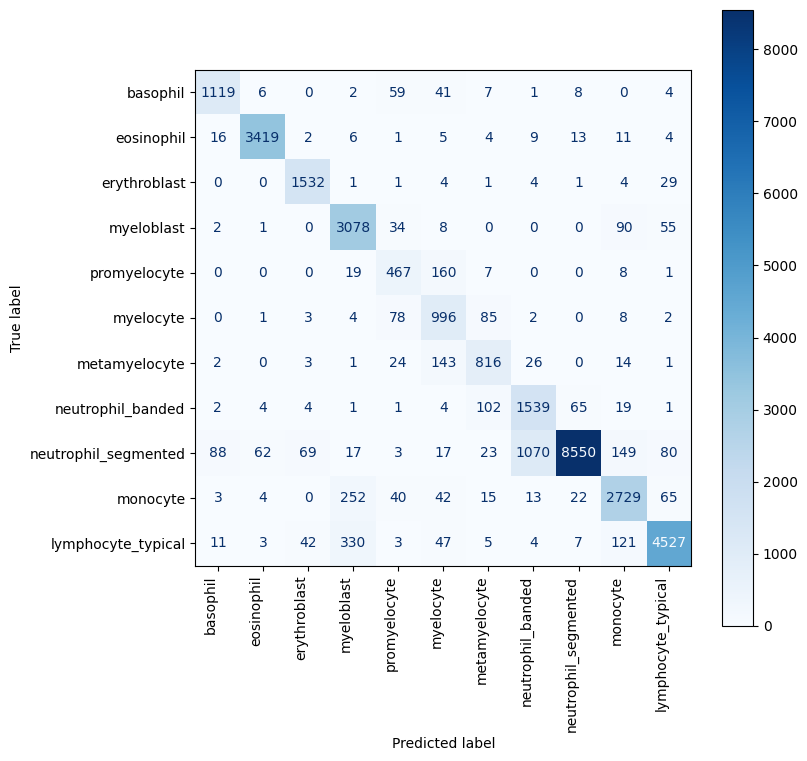

In [142]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))

cf_matrix = confusion_matrix(y_test,  y_pred)
disp = ConfusionMatrixDisplay(cf_matrix, display_labels=label_map_all.keys())
disp.plot(cmap=plt.cm.Blues, ax=ax)
_ = ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')